# Resampling ~ Sex

In [1]:
# Import libraries and filter warnings
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN
from aif360.datasets import BinaryLabelDataset
from aif360.metrics import ClassificationMetric
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

2024-09-09 00:54:11.582316: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/elton/anaconda3/envs/Dissertation/lib/python3.11/site-packages/torch/_functorch/deprecated.py:61: UserWarning: We've integrated functorch into PyTorch. As the final step of the integration, functorch.vmap is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use torch.vmap instead; see the PyTorch 2.0 release notes and/or the torch.func migration guide for more details https://pytorch.org/docs/master/func.migrating.html
  warn_deprecated('vmap', 'torch.vmap')


In [2]:
# Load data
train = pd.read_csv(r'../Resources/Data/baseline_train_data.csv')
test = pd.read_csv(r'../Resources/Data/baseline_test_data.csv')
valid = pd.read_csv(r'../Resources/Data/baseline_valis_data.csv')

target = 'two_year_recid'

# Separate features and target for training, testing, and validation data
X_train = train.drop(columns=[target])
y_train = train[target]

X_test = test.drop(columns=[target])
y_test = test[target]

X_valid = valid.drop(columns=[target])
y_valid = valid[target]

# Defining sampling strategies
over_sampler = SMOTE(random_state=42)
under_sampler = RandomUnderSampler(random_state=42)
combined_sampler = SMOTEENN(random_state=42)

In [3]:
# Function to train and evaluate the model with different sampling techniques
def evaluate_fairness(X_train, y_train, sampling_strategy=None):
    if sampling_strategy:
        X_train, y_train = sampling_strategy.fit_resample(X_train, y_train)
    
    log_reg = LogisticRegression(max_iter=1000)
    log_reg.fit(X_train, y_train)
    
    y_pred_test = log_reg.predict(X_test)

    print(f'Test Accuracy: {accuracy_score(y_test, y_pred_test)}')

    cm = confusion_matrix(y_test, y_pred_test)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()
    
    # Convert to AIF360's BinaryLabelDataset format
    test_aif = BinaryLabelDataset(df=pd.concat([X_test, y_test], axis=1),
                                  label_names=[target],
                                  protected_attribute_names=['sex'])
    
    test_aif_pred = BinaryLabelDataset(df=pd.concat([X_test, pd.Series(y_pred_test, name=target)], axis=1),
                                       label_names=[target],
                                       protected_attribute_names=['sex'])
    
    # Define privileged and unprivileged groups
    privileged_groups = [{'sex': 1}]
    unprivileged_groups = [{'sex': 0}]
    
    # Compute fairness metrics
    metric_test_pred = ClassificationMetric(test_aif, test_aif_pred,
                                            unprivileged_groups=unprivileged_groups,
                                            privileged_groups=privileged_groups)
    
    stat_parity_diff = metric_test_pred.statistical_parity_difference()
    avg_odds_diff = metric_test_pred.average_odds_difference()
    equal_opp_diff = metric_test_pred.equal_opportunity_difference()
    
    print(f"Sampling Strategy: {sampling_strategy.__class__.__name__ if sampling_strategy else 'None'}")
    print(f"Statistical Parity Difference: {stat_parity_diff}")
    print(f"Average Odds Difference: {avg_odds_diff}")
    print(f"Equal Opportunity Difference: {equal_opp_diff}")
    print()

With Over-Sampling (SMOTE):
Test Accuracy: 0.6502525252525253


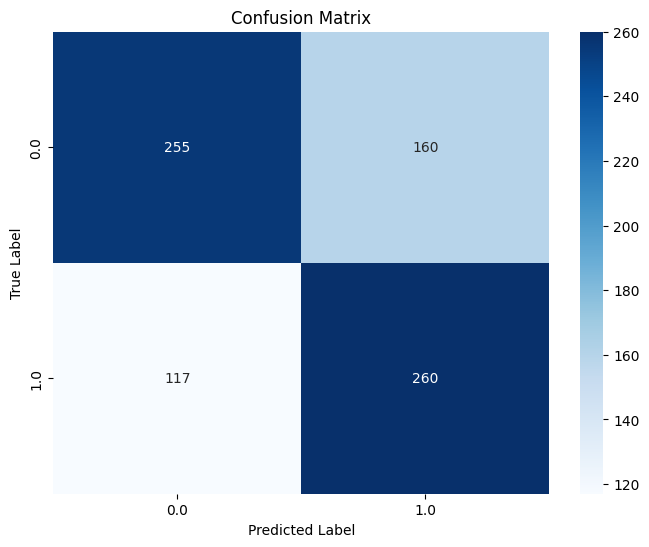

Sampling Strategy: SMOTE
Statistical Parity Difference: 0.32795719619692826
Average Odds Difference: 0.315755227048678
Equal Opportunity Difference: 0.3286319394376352

With Under-Sampling (RandomUnderSampler):
Test Accuracy: 0.6464646464646465


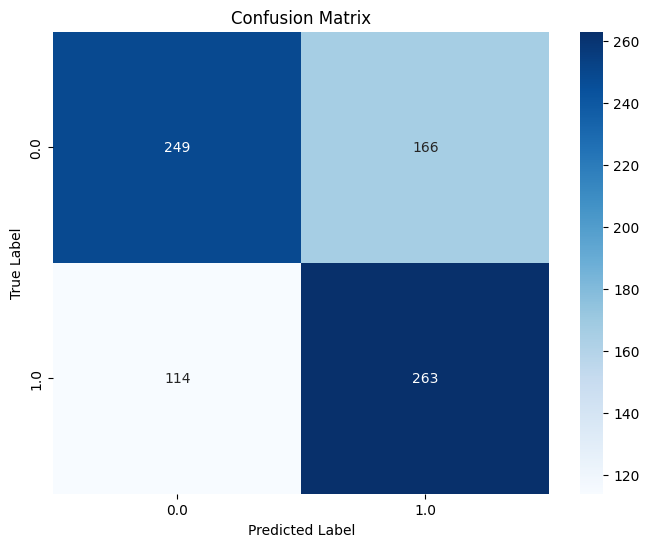

Sampling Strategy: RandomUnderSampler
Statistical Parity Difference: 0.3423341930020401
Average Odds Difference: 0.3300062077613293
Equal Opportunity Difference: 0.3385003604902668

With Combined Sampling (SMOTE + ENN):
Test Accuracy: 0.63510101010101


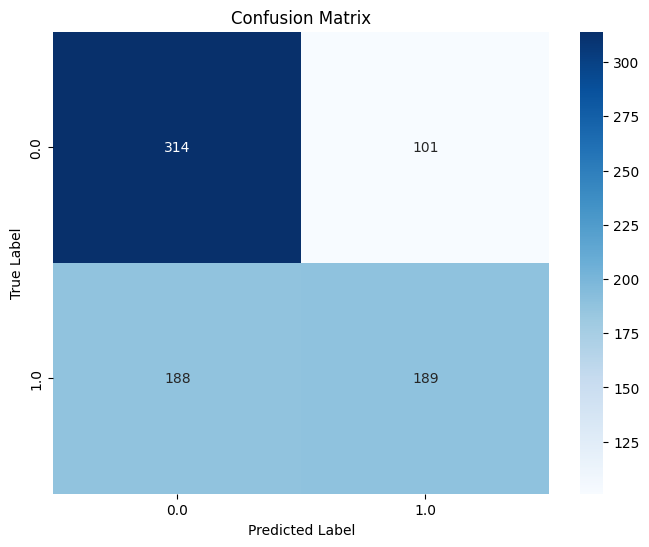

Sampling Strategy: SMOTEENN
Statistical Parity Difference: 0.1736402478925286
Average Odds Difference: 0.1636925422140531
Equal Opportunity Difference: 0.180019826964672



In [4]:
# Evaluate the model with different sampling strategies
print("With Over-Sampling (SMOTE):")
evaluate_fairness(X_train, y_train, over_sampler)

print("With Under-Sampling (RandomUnderSampler):")
evaluate_fairness(X_train, y_train, under_sampler)

print("With Combined Sampling (SMOTE + ENN):")
evaluate_fairness(X_train, y_train, combined_sampler)